In [1]:
import os, json
from utils import session_config
from data_loader import load_data, Episode_generator
from models import load_model
from trainers.train_utils import calc_prototypes, calc_euclidian_dists, calc_probability_with_dists, loss_func, cal_metric

from functools import partial
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
session_config.setup_gpus(True, 0.9)

1 Physical GPUs, 1 Logical GPUs


# 1. load configuration file

In [3]:
config_filename = "configs/mini_imagenet_fsl.json"

In [4]:
with open(config_filename, "r") as file:
    config = json.load(file)

In [5]:
print(config)

{'dataset_name': 'mini_imagenet', 'data_dir': '/home/files/datasets/mini_imagenet', 'input_shape': [84, 84, 3], 'model_name': 'prototypical_networks', 'checkpoint_dir': 'checkpoints/protonet_lr_up', 'train': {'gpu_id': '0', 'n_epoch': 300, 'n_episode': 100, 'n_way': 30, 'n_support': 5, 'n_query': 15, 'learning_rate': 0.005, 'patience': 50, 'pretrained_type': 'base', 'checkpoint_name': 'None'}, 'test': {'gpu_id': '0', 'n_episode': 100, 'n_way': 5, 'n_support': 5, 'n_query': 15, 'pretrained_type': 'latest', 'checkpoint_name': 'None'}}


In [6]:
print(config["train"])

{'gpu_id': '0', 'n_epoch': 300, 'n_episode': 100, 'n_way': 30, 'n_support': 5, 'n_query': 15, 'learning_rate': 0.005, 'patience': 50, 'pretrained_type': 'base', 'checkpoint_name': 'None'}


In [7]:
print(config["test"])

{'gpu_id': '0', 'n_episode': 100, 'n_way': 5, 'n_support': 5, 'n_query': 15, 'pretrained_type': 'latest', 'checkpoint_name': 'None'}


# 2. load data pipeline

In [8]:
#ds = load_data(["train", "val", "test"], config)
ds = load_data(["train", "val", "test"], config)

In [9]:
ds["val"].shape #shape of data

(16, 600, 84, 84, 3)

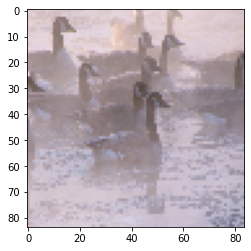

In [10]:
plt.imshow(ds["val"][0,0])

In [11]:
print(ds["val"][0,0,:10,:10])

[[[0.8745098  0.8        0.78431373]
  [0.85882353 0.78431373 0.76862745]
  [0.85098039 0.77647059 0.76078431]
  [0.85490196 0.77647059 0.78431373]
  [0.87843137 0.8        0.80392157]
  [0.83921569 0.76470588 0.74901961]
  [0.83921569 0.76862745 0.76470588]
  [0.8745098  0.81176471 0.81960784]
  [0.87058824 0.79607843 0.80392157]
  [0.85490196 0.78039216 0.80392157]]

 [[0.89803922 0.83529412 0.83921569]
  [0.8745098  0.80784314 0.81176471]
  [0.87058824 0.80784314 0.81176471]
  [0.85882353 0.78039216 0.78823529]
  [0.83529412 0.75686275 0.76078431]
  [0.82745098 0.75294118 0.75686275]
  [0.82745098 0.75294118 0.76078431]
  [0.85490196 0.78823529 0.81176471]
  [0.84313725 0.76862745 0.79215686]
  [0.83137255 0.75686275 0.77254902]]

 [[0.85098039 0.77647059 0.78431373]
  [0.85882353 0.78431373 0.79215686]
  [0.90980392 0.83529412 0.84313725]
  [0.88235294 0.80392157 0.80784314]
  [0.83529412 0.75686275 0.76470588]
  [0.82352941 0.76078431 0.76470588]
  [0.83921569 0.76862745 0.7764705

In [12]:
n_way = config["train"]["n_way"]
n_support = config["train"]["n_support"]
n_query = config["train"]["n_query"]
Epi_gen = Episode_generator(ds["train"], n_way, n_support, n_query)
train_ds = Epi_gen.pipeline()


val_n_way = config["test"]["n_way"]
val_n_support = config["test"]["n_support"]
val_n_query = config["test"]["n_query"]
Epi_gen = Episode_generator(ds["val"], val_n_way, val_n_support, val_n_query)
val_ds = Epi_gen.pipeline()

Epi_gen = Episode_generator(ds["test"], val_n_way, val_n_support, val_n_query)
test_ds = Epi_gen.pipeline()

In [13]:
for i, (support,query) in enumerate(train_ds.take(1)):
    print("{}-th episode".format(i+1))
    print("support set", support.shape)
    print("query set", query.shape)

1-th episode
support set (30, 5, 84, 84, 3)
query set (30, 15, 84, 84, 3)


In [14]:
for i, (support,query) in enumerate(val_ds.take(1)):
    print("{}-th episode".format(i+1))
    print("support set", support.shape)
    print("query set", query.shape)

1-th episode
support set (5, 5, 84, 84, 3)
query set (5, 15, 84, 84, 3)


In [15]:
for i, (support,query) in enumerate(test_ds.take(1)):
    print("{}-th episode".format(i+1))
    print("support set", support.shape)
    print("query set", query.shape)

1-th episode
support set (5, 5, 84, 84, 3)
query set (5, 15, 84, 84, 3)


# 1. load Prototypical network 

In [16]:
model = load_model(config)

In [17]:
H,W,C = config["input_shape"]
model(np.ones([1,H,W,C], np.float32))

<tf.Tensor: shape=(1, 1600), dtype=float32, numpy=
array([[0.09665662, 0.04805043, 0.08951066, ..., 0.04444581, 0.13337615,
        0.        ]], dtype=float32)>

In [18]:
model.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (1, 84, 84, 64)           1792      
_________________________________________________________________
batch_normalization (BatchNo (1, 84, 84, 64)           256       
_________________________________________________________________
re_lu (ReLU)                 (1, 84, 84, 64)           0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (1, 42, 42, 64)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 42, 42, 64)           36928     
_________________________________________________________________
batch_normalization_1 (Batch (1, 42, 42, 64)           256       
_________________________________________________________________
re_lu_1 (ReLU)               (1, 42, 42, 64)           0

# Training

In [19]:
log_dir = os.path.join('logs', "protonet")
if os.path.isdir(log_dir):
        raise ValueError("log directory exists. checkout your experiment name in configure file.")
summary_writer = tf.summary.create_file_writer(log_dir)

In [20]:
@tf.function
def train_step(query, support, model, optimizer, n_way, n_query, n_support):
    with tf.GradientTape() as tape:
        query_embeddings = model(query)
        support_embeddings = model(support)

        prototypes = calc_prototypes(support_embeddings, n_way, n_support)
        dists = calc_euclidian_dists(query_embeddings, prototypes)
        log_p_y = calc_probability_with_dists(dists, n_way, n_query)
        loss, pred = loss_func(log_p_y, n_way, n_query)
        eq, acc = cal_metric(log_p_y, n_way, n_query)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, eq, acc

@tf.function
def val_step(query, support, model, n_way, n_query, n_support):
    query_embeddings = model(query)
    support_embeddings = model(support)
    
    prototypes = calc_prototypes(support_embeddings, n_way, n_support)
    dists = calc_euclidian_dists(query_embeddings, prototypes)
    log_p_y = calc_probability_with_dists(dists, n_way, n_query)
    loss, pred = loss_func(log_p_y, n_way, n_query)
    eq, acc = cal_metric(log_p_y, n_way, n_query)
    return loss, eq, acc

In [21]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=config["train"]["learning_rate"])

n_epoch = config["train"]["n_epoch"]
n_episode = config["train"]["n_episode"]
val_n_episode = config["test"]["n_episode"]

trainer = partial(train_step, model=model, optimizer=adam_optimizer, n_way=n_way, n_query=n_query, n_support=n_support)
validator = partial(val_step, model=model, n_way=val_n_way, n_query=val_n_query, n_support=val_n_support)

In [22]:
for epoch in range(n_epoch):
    train_loss = tf.metrics.Mean(name='train_loss')
    val_loss = tf.metrics.Mean(name='val_loss')
    train_acc = tf.metrics.Mean(name='train_accuracy')
    val_acc = tf.metrics.Mean(name='val_accuracy')
    
    print("{} epoch start".format(epoch+1))
    #Training
    for episode, (support, query) in enumerate(train_ds):
        query = tf.reshape(query, [-1,H,W,C])
        support = tf.reshape(support, [-1,H,W,C])
        loss, eq, acc = trainer(query, support)
        train_loss(loss)
        train_acc(acc)
        if ((episode+1)%20) == 0:
            print("Episode {}".format(episode+1))
        if episode+1 == n_episode:
            break
    #validation 
    for episode, (support, query) in enumerate(val_ds):
        query = tf.reshape(query, [-1,H,W,C])
        support = tf.reshape(support, [-1,H,W,C])
        loss, eq, acc = validator(query, support)
        val_loss(loss)
        val_acc(acc)
        if episode+1 == val_n_episode:
            break
    print("{} epoch end. Loss : {}, Accuracy : {}, Val-loss : {}, Val-Accuracy : {}".format(epoch+1, 
                                                                                             train_loss.result(),
                                                                                             train_acc.result(),
                                                                                             val_loss.result(),
                                                                                             val_acc.result() ))
    with summary_writer.as_default():
                tf.summary.scalar('train_loss', train_loss.result(), step=epoch)
                tf.summary.scalar('train_acc', train_acc.result(), step=epoch)
                tf.summary.scalar('val_loss', val_loss.result(), step=epoch)
                tf.summary.scalar('val_acc', val_acc.result(), step=epoch)

1 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
1 epoch end. Loss : 3.2203638553619385, Accuracy : 0.12186665832996368, Val-loss : 1.5176758766174316, Val-Accuracy : 0.35893335938453674
2 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
2 epoch end. Loss : 3.073758602142334, Accuracy : 0.15506665408611298, Val-loss : 1.4576340913772583, Val-Accuracy : 0.390666663646698
3 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
3 epoch end. Loss : 2.998387336730957, Accuracy : 0.17251111567020416, Val-loss : 1.4197468757629395, Val-Accuracy : 0.41439998149871826
4 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
4 epoch end. Loss : 2.9088239669799805, Accuracy : 0.19104446470737457, Val-loss : 1.3702205419540405, Val-Accuracy : 0.4496000409126282
5 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
5 epoch end. Loss : 2.845555067062378, Accuracy : 0.2097555696964264, Val-loss : 1.290061354637146, Val

Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
41 epoch end. Loss : 1.9284143447875977, Accuracy : 0.42888885736465454, Val-loss : 0.9307921528816223, Val-Accuracy : 0.6327999234199524
42 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
42 epoch end. Loss : 1.9083774089813232, Accuracy : 0.43328872323036194, Val-loss : 0.999840259552002, Val-Accuracy : 0.6110666394233704
43 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
43 epoch end. Loss : 1.8952195644378662, Accuracy : 0.43806660175323486, Val-loss : 0.9693341255187988, Val-Accuracy : 0.6138666272163391
44 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
44 epoch end. Loss : 1.872431755065918, Accuracy : 0.4430445432662964, Val-loss : 0.9409207105636597, Val-Accuracy : 0.6337333917617798
45 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
45 epoch end. Loss : 1.8690965175628662, Accuracy : 0.44495564699172974, Val-loss : 0.9618404507637024, Val-Acc

Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
81 epoch end. Loss : 1.7092807292938232, Accuracy : 0.4850442409515381, Val-loss : 0.9753011465072632, Val-Accuracy : 0.6253331899642944
82 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
82 epoch end. Loss : 1.708443284034729, Accuracy : 0.48239997029304504, Val-loss : 0.9709362983703613, Val-Accuracy : 0.6233331561088562
83 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
83 epoch end. Loss : 1.6859112977981567, Accuracy : 0.49362221360206604, Val-loss : 0.9542543888092041, Val-Accuracy : 0.6218665838241577
84 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
84 epoch end. Loss : 1.6794068813323975, Accuracy : 0.49228888750076294, Val-loss : 0.9751377105712891, Val-Accuracy : 0.612266480922699
85 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
85 epoch end. Loss : 1.691327691078186, Accuracy : 0.4880000054836273, Val-loss : 0.9373652935028076, Val-Accur

Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
121 epoch end. Loss : 1.5878454446792603, Accuracy : 0.5120889544487, Val-loss : 0.9422226548194885, Val-Accuracy : 0.6307998895645142
122 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
122 epoch end. Loss : 1.6021167039871216, Accuracy : 0.511888861656189, Val-loss : 0.9582902789115906, Val-Accuracy : 0.6181333661079407
123 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
123 epoch end. Loss : 1.5750737190246582, Accuracy : 0.5185777544975281, Val-loss : 0.978334903717041, Val-Accuracy : 0.6206665635108948
124 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
124 epoch end. Loss : 1.593235731124878, Accuracy : 0.5110888481140137, Val-loss : 1.0017623901367188, Val-Accuracy : 0.6081331968307495
125 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
125 epoch end. Loss : 1.5720843076705933, Accuracy : 0.5197778344154358, Val-loss : 0.9846075177192688, Val-Ac

Episode 100
160 epoch end. Loss : 1.5114526748657227, Accuracy : 0.5311112999916077, Val-loss : 0.9614511728286743, Val-Accuracy : 0.6317332983016968
161 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
161 epoch end. Loss : 1.5388790369033813, Accuracy : 0.5236221551895142, Val-loss : 0.9902602434158325, Val-Accuracy : 0.6166667342185974
162 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
162 epoch end. Loss : 1.527561902999878, Accuracy : 0.5299777388572693, Val-loss : 1.0116456747055054, Val-Accuracy : 0.6093333959579468
163 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
163 epoch end. Loss : 1.524422287940979, Accuracy : 0.5273334383964539, Val-loss : 0.9970323443412781, Val-Accuracy : 0.611599862575531
164 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
164 epoch end. Loss : 1.5339807271957397, Accuracy : 0.5263778567314148, Val-loss : 1.0038756132125854, Val-Accuracy : 0.6041333675384521
165 epoch sta

Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
200 epoch end. Loss : 1.4766721725463867, Accuracy : 0.5390445590019226, Val-loss : 0.9867241382598877, Val-Accuracy : 0.6173332333564758
201 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
201 epoch end. Loss : 1.4712144136428833, Accuracy : 0.5464666485786438, Val-loss : 0.9991602897644043, Val-Accuracy : 0.6140000224113464
202 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
202 epoch end. Loss : 1.5097377300262451, Accuracy : 0.533133327960968, Val-loss : 0.9978049993515015, Val-Accuracy : 0.6269331574440002
203 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
203 epoch end. Loss : 1.4755558967590332, Accuracy : 0.5435110926628113, Val-loss : 1.0747764110565186, Val-Accuracy : 0.5883998870849609
204 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
204 epoch end. Loss : 1.4795293807983398, Accuracy : 0.5398889780044556, Val-loss : 1.0365957021713257, V

Episode 100
239 epoch end. Loss : 1.4483221769332886, Accuracy : 0.5504888296127319, Val-loss : 1.022710919380188, Val-Accuracy : 0.6041333675384521
240 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
240 epoch end. Loss : 1.44695246219635, Accuracy : 0.5478666424751282, Val-loss : 1.0259971618652344, Val-Accuracy : 0.6083999872207642
241 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
241 epoch end. Loss : 1.4397817850112915, Accuracy : 0.5504444241523743, Val-loss : 1.039413571357727, Val-Accuracy : 0.607999861240387
242 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
242 epoch end. Loss : 1.4524741172790527, Accuracy : 0.5468222498893738, Val-loss : 1.0581274032592773, Val-Accuracy : 0.5902668237686157
243 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
243 epoch end. Loss : 1.4617961645126343, Accuracy : 0.5434000492095947, Val-loss : 1.0314931869506836, Val-Accuracy : 0.5990665555000305
244 epoch start

Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
279 epoch end. Loss : 1.3907065391540527, Accuracy : 0.5613778233528137, Val-loss : 1.013575792312622, Val-Accuracy : 0.6128000020980835
280 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
280 epoch end. Loss : 1.412489891052246, Accuracy : 0.5593999624252319, Val-loss : 1.0315660238265991, Val-Accuracy : 0.6013332009315491
281 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
281 epoch end. Loss : 1.4021295309066772, Accuracy : 0.5603333115577698, Val-loss : 1.0299351215362549, Val-Accuracy : 0.6032000780105591
282 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
282 epoch end. Loss : 1.416049838066101, Accuracy : 0.5581777691841125, Val-loss : 1.0128848552703857, Val-Accuracy : 0.6057332754135132
283 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
283 epoch end. Loss : 1.4257465600967407, Accuracy : 0.5511999726295471, Val-loss : 1.0264413356781006, Val

In [23]:
model.save('protonet.h5')

# Accuracy test

In [24]:
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')
for epoch in range(n_epoch):
    print("{} epoch start".format(epoch+1)) 
    for episode, (support, query) in enumerate(val_ds):
        query = tf.reshape(query, [-1,H,W,C])
        support = tf.reshape(support, [-1,H,W,C])
        loss, eq, acc = validator(query, support)
        val_loss(loss)
        val_acc(acc)
        if episode+1 == val_n_episode:
            break
    print("{} epoch end. Loss : {}, Accuracy : {}, Val-loss : {}, Val-Accuracy : {}".format(epoch+1, 
                                                                                             train_loss.result(),
                                                                                             train_acc.result(),
                                                                                             val_loss.result(),
                                                                                             val_acc.result() ))

1 epoch start
1 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0324578285217285, Val-Accuracy : 0.5937331914901733
2 epoch start
2 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0321099758148193, Val-Accuracy : 0.5944000482559204
3 epoch start
3 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0352091789245605, Val-Accuracy : 0.593666672706604
4 epoch start
4 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0381343364715576, Val-Accuracy : 0.592346727848053
5 epoch start
5 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.037818193435669, Val-Accuracy : 0.5936446189880371
6 epoch start
6 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0373963117599487, Val-Accuracy : 0.5931048393249512
7 epoch start
7 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.04193

56 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0336320400238037, Val-Accuracy : 0.5956573486328125
57 epoch start
57 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.033230185508728, Val-Accuracy : 0.5957643985748291
58 epoch start
58 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0325270891189575, Val-Accuracy : 0.5960646867752075
59 epoch start
59 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0320050716400146, Val-Accuracy : 0.5962879657745361
60 epoch start
60 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0324904918670654, Val-Accuracy : 0.5961213111877441
61 epoch start
61 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0327924489974976, Val-Accuracy : 0.5961087942123413
62 epoch start
62 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0324

110 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0353578329086304, Val-Accuracy : 0.5945175886154175
111 epoch start
111 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0354702472686768, Val-Accuracy : 0.5944904685020447
112 epoch start
112 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0355151891708374, Val-Accuracy : 0.594451904296875
113 epoch start
113 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0357776880264282, Val-Accuracy : 0.5943577289581299
114 epoch start
114 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0356718301773071, Val-Accuracy : 0.5943892002105713
115 epoch start
115 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.035854697227478, Val-Accuracy : 0.5943293571472168
116 epoch start
116 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-l

164 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0360709428787231, Val-Accuracy : 0.5942445993423462
165 epoch start
165 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0362272262573242, Val-Accuracy : 0.594231903553009
166 epoch start
166 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0362403392791748, Val-Accuracy : 0.5942335724830627
167 epoch start
167 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0363092422485352, Val-Accuracy : 0.5942289233207703
168 epoch start
168 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0362718105316162, Val-Accuracy : 0.5942584276199341
169 epoch start
169 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0363353490829468, Val-Accuracy : 0.5941768288612366
170 epoch start
170 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-

218 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0369216203689575, Val-Accuracy : 0.593819797039032
219 epoch start
219 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0369032621383667, Val-Accuracy : 0.5938411951065063
220 epoch start
220 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0367408990859985, Val-Accuracy : 0.5938984751701355
221 epoch start
221 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0366957187652588, Val-Accuracy : 0.5938969850540161
222 epoch start
222 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.036538004875183, Val-Accuracy : 0.5939839482307434
223 epoch start
223 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0365833044052124, Val-Accuracy : 0.5939785838127136
224 epoch start
224 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-l

272 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.036720633506775, Val-Accuracy : 0.5938463807106018
273 epoch start
273 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0366065502166748, Val-Accuracy : 0.5938791036605835
274 epoch start
274 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0364975929260254, Val-Accuracy : 0.5938994884490967
275 epoch start
275 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0365262031555176, Val-Accuracy : 0.593891441822052
276 epoch start
276 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0365424156188965, Val-Accuracy : 0.5938737392425537
277 epoch start
277 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-loss : 1.0365662574768066, Val-Accuracy : 0.5938851237297058
278 epoch start
278 epoch end. Loss : 1.4174367189407349, Accuracy : 0.5552889108657837, Val-l